In [28]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from torch import from_numpy
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt


## ETL

In [9]:
# Load the data
folder = 'data/Iris.csv'
data = pd.read_csv(folder)

# Display the first few rows of the data
data.head()

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa


In [10]:
# Drop the Id column
data = data.drop(columns=['Id'])

# Separate features and target
X = data.drop(columns=['Species']).values
y = data['Species'].values

In [19]:
# Scale features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Encode labels
encoder = LabelEncoder()
y = encoder.fit_transform(y)

# Convert numpy arrays to PyTorch tensors
X = from_numpy(X).float()
y = from_numpy(y)

# Convert labels to one-hot encoding
#y = torch.nn.functional.one_hot(y)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Determine the number of classes
num_classes = max(y) + 1
num_features = X.shape[1]

num_classes, num_features

(tensor(3), 4)

## Model and train

In [22]:
class MLPWithActivations(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, num_classes):
        super(MLPWithActivations, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size1)
        self.layer2 = nn.Linear(hidden_size1, hidden_size2)
        self.layer3 = nn.Linear(hidden_size2, num_classes)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)
        
        # Activations placeholder
        self.activations = {}
        
    def forward(self, x):
        self.activations['input'] = x
        out = self.layer1(x)
        self.activations['layer1'] = out
        out = self.relu(out)
        out = self.layer2(out)
        self.activations['layer2'] = out
        out = self.relu(out)
        out = self.layer3(out)
        self.activations['layer3'] = out
        out = self.softmax(out)
        return out

In [24]:
# Convert data to tensors
tensor_x_train = torch.Tensor(X_train)
tensor_y_train = torch.LongTensor(y_train)
tensor_x_test = torch.Tensor(X_test)
tensor_y_test = torch.LongTensor(y_test)

# Create a TensorDataset from the data
train_data = TensorDataset(tensor_x_train, tensor_y_train)
test_data = TensorDataset(tensor_x_test, tensor_y_test)

# Create a DataLoader from the TensorDataset
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

In [26]:
# Initialize the MLP
model = MLPWithActivations(num_features, 100, 20, num_classes)

# Define the loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

# Function to perform a training step
def train_step(model, train_loader, criterion, optimizer):
    model.train()
    running_loss = 0
    corrects = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        corrects += torch.sum(preds == labels.data)
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = corrects.double() / len(train_loader.dataset)
    return epoch_loss, epoch_acc.item()

# Train the model for 10 epochs
num_epochs = 10
for epoch in range(num_epochs):
    train_loss, train_acc = train_step(model, train_loader, criterion, optimizer)
    print(f'Epoch: {epoch+1}/{num_epochs} | Loss: {train_loss:.4f} | Acc: {train_acc:.4f}')


Epoch: 1/10 | Loss: 1.0841 | Acc: 0.5250
Epoch: 2/10 | Loss: 1.0603 | Acc: 0.8250
Epoch: 3/10 | Loss: 1.0361 | Acc: 0.8250
Epoch: 4/10 | Loss: 1.0089 | Acc: 0.8000
Epoch: 5/10 | Loss: 0.9816 | Acc: 0.7583
Epoch: 6/10 | Loss: 0.9511 | Acc: 0.7250
Epoch: 7/10 | Loss: 0.9231 | Acc: 0.7167
Epoch: 8/10 | Loss: 0.8945 | Acc: 0.7167
Epoch: 9/10 | Loss: 0.8702 | Acc: 0.7167
Epoch: 10/10 | Loss: 0.8489 | Acc: 0.7333


In [27]:
# Pass a sample input through the model to get the activations
sample_input = X_train[0].unsqueeze(0)
sample_output = model(sample_input)

# Print the activations
for name, activation in model.activations.items():
    print(f'{name}: {activation}')

input: tensor([[-1.5065,  1.2635, -1.5687, -1.3130]])
layer1: tensor([[-0.4594, -1.3861,  0.3512,  0.0167, -0.6968, -0.3367,  1.1238,  0.0106,
          0.6090, -0.7266,  0.3383, -0.5137,  1.2091,  2.5426, -0.3955, -0.6907,
         -0.0207, -1.5283,  1.4622, -0.7520, -1.4646,  1.3475,  0.9380,  0.4178,
          0.8682, -1.8994, -0.7790, -1.5055, -0.8672, -0.4075, -1.3546,  0.8667,
         -0.3530,  1.3534, -1.3508,  0.7152, -0.4681,  2.0408,  1.7977,  0.6726,
          1.9233, -0.7029, -1.1889,  1.1922,  0.3272,  0.7013,  1.4259, -0.3044,
          1.5619,  0.5423,  0.5491,  0.2382, -1.2353,  1.1617, -0.4230,  1.3617,
         -0.0170,  1.1615,  1.8676, -0.5271, -0.4026, -0.1157, -1.2382,  0.0495,
          0.1602, -0.9525, -1.4336,  1.3290,  0.8835, -0.0542, -1.1864, -0.8757,
         -1.2763,  0.8128,  1.0713, -0.4181,  0.3327, -0.0089, -1.3457, -1.0557,
         -0.2900,  0.1557,  1.0088, -0.2471, -0.2401, -1.3621,  1.1367,  1.3606,
         -0.3725, -0.0382,  0.6511,  0.4775,  1

## Activation function

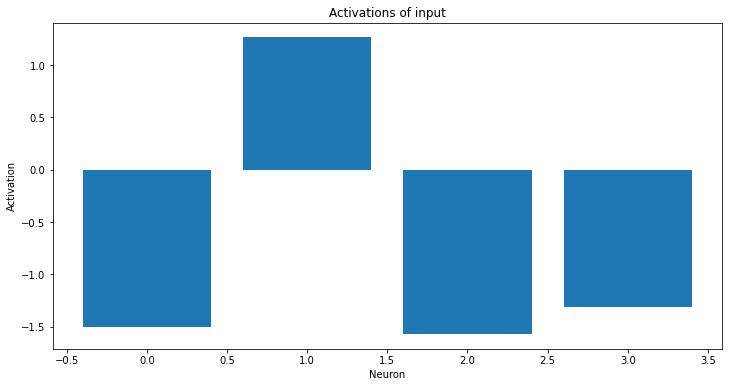

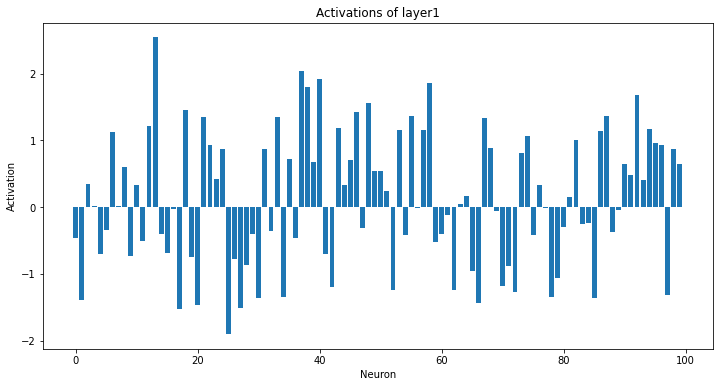

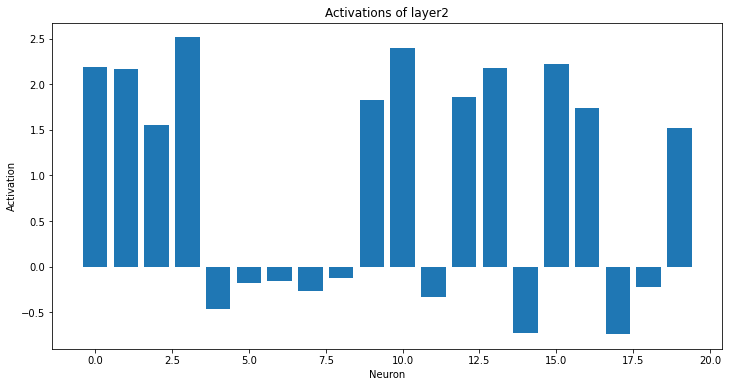

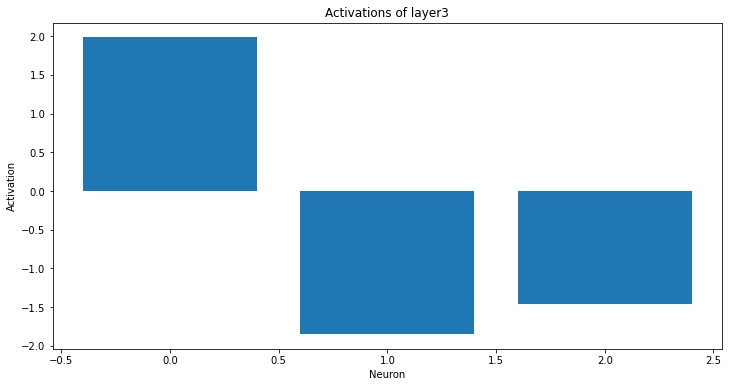

In [29]:
# Function to plot the activations
def plot_activations(activations):
    for layer_name, activation in activations.items():
        plt.figure(figsize=(12, 6))
        plt.bar(range(activation.shape[1]), activation.detach().numpy()[0])
        plt.title(f'Activations of {layer_name}')
        plt.xlabel('Neuron')
        plt.ylabel('Activation')
        plt.show()

# Plot the activations
plot_activations(model.activations)

In [31]:
from sklearn.utils import resample

# Convert test data back to DataFrame for easier manipulation
df_test = pd.DataFrame(tensor_x_test.numpy(), columns=data.columns[:-1])
df_test['Species'] = tensor_y_test.numpy()

# Separate the test data by class
df_test_setosa = df_test[df_test['Species'] == 0]
df_test_versicolor = df_test[df_test['Species'] == 1]
df_test_virginica = df_test[df_test['Species'] == 2]

# Find the number of examples in the smallest class
min_examples = min(len(df_test_setosa), len(df_test_versicolor), len(df_test_virginica))

# Resample each class to have the same number of examples as the smallest class
df_test_setosa_resampled = resample(df_test_setosa, replace=False, n_samples=min_examples, random_state=42)
df_test_versicolor_resampled = resample(df_test_versicolor, replace=False, n_samples=min_examples, random_state=42)
df_test_virginica_resampled = resample(df_test_virginica, replace=False, n_samples=min_examples, random_state=42)

# Concatenate the resampled dataframes back together
df_test_balanced = pd.concat([df_test_setosa_resampled, df_test_versicolor_resampled, df_test_virginica_resampled])

# Separate features and labels
X_test_balanced = df_test_balanced.drop(columns=['Species']).values
y_test_balanced = df_test_balanced['Species'].values

# Convert to PyTorch tensors
X_test_balanced = torch.Tensor(X_test_balanced)
y_test_balanced = torch.LongTensor(y_test_balanced)

X_test_balanced.shape, y_test_balanced.shape


(torch.Size([27, 4]), torch.Size([27]))

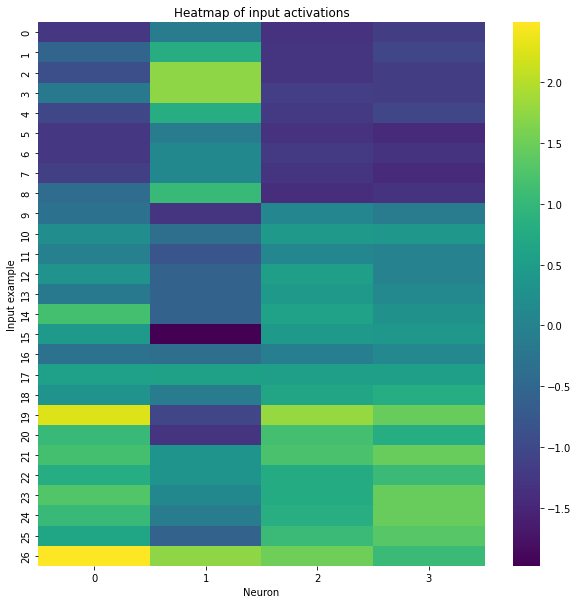

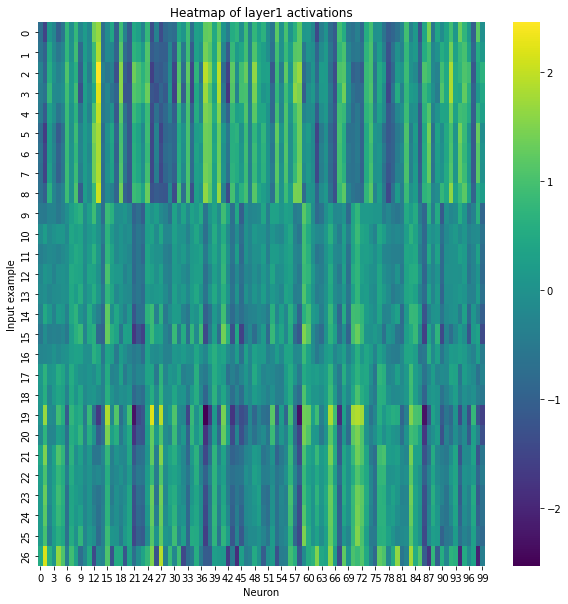

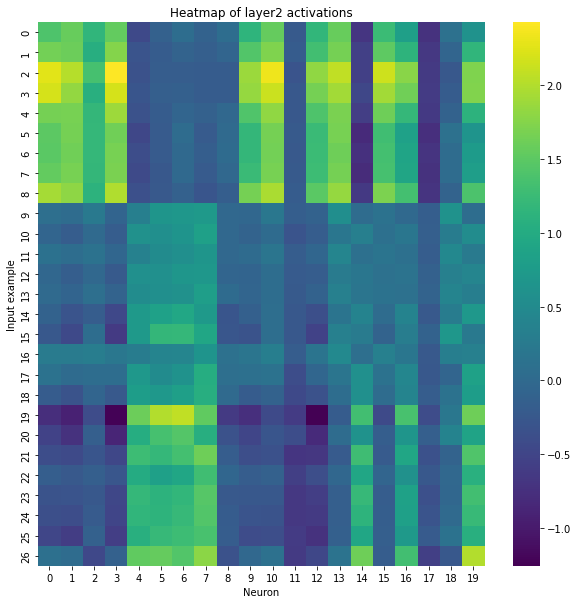

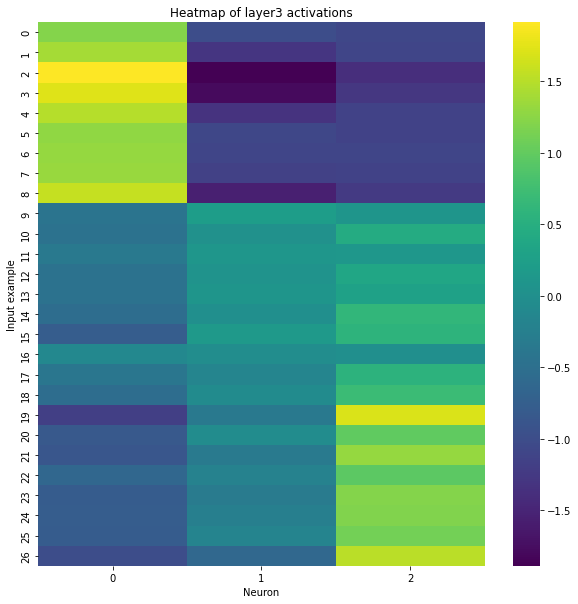

In [32]:
import seaborn as sns

# Function to plot the heatmaps of activations
def plot_activation_heatmaps(model, inputs):
    # Pass inputs through the model
    outputs = model(inputs)
    # Create a heatmap for each layer's activations
    for layer_name, activation in model.activations.items():
        plt.figure(figsize=(10, 10))
        sns.heatmap(activation.detach().numpy(), cmap='viridis')
        plt.title(f'Heatmap of {layer_name} activations')
        plt.xlabel('Neuron')
        plt.ylabel('Input example')
        plt.show()

# Plot the activation heatmaps
plot_activation_heatmaps(model, X_test_balanced)


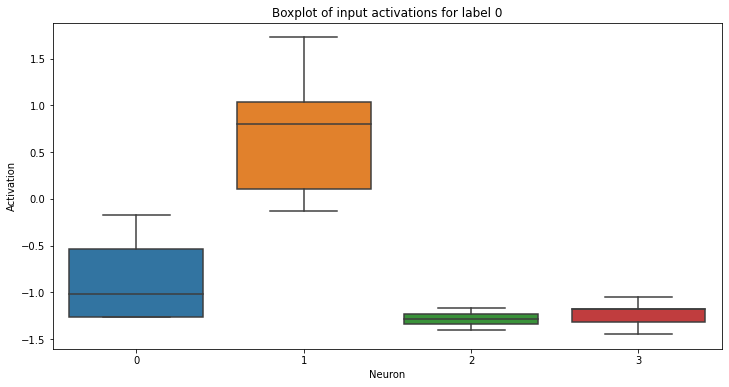

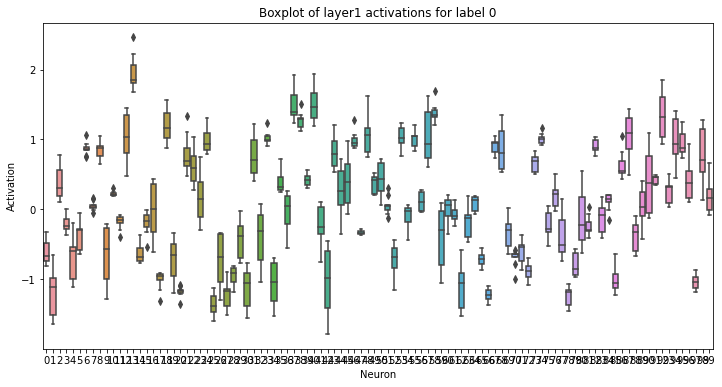

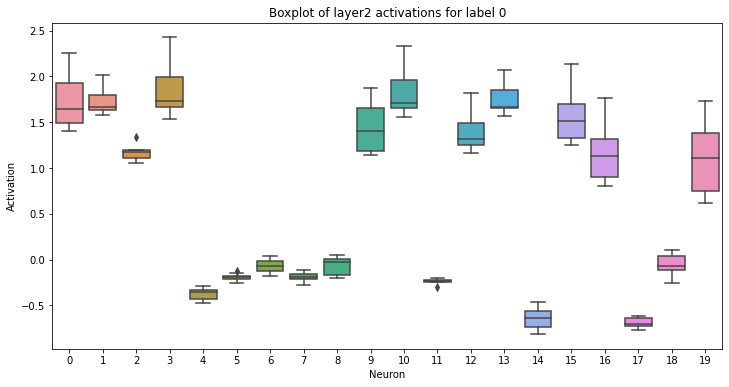

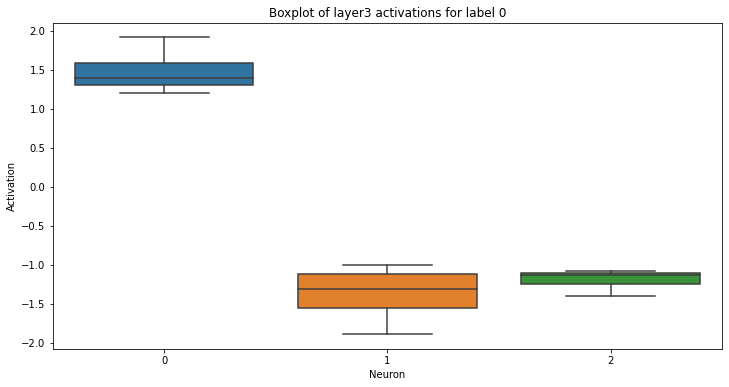

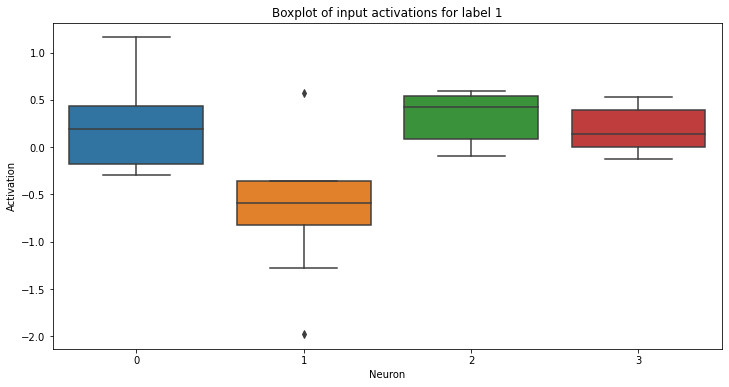

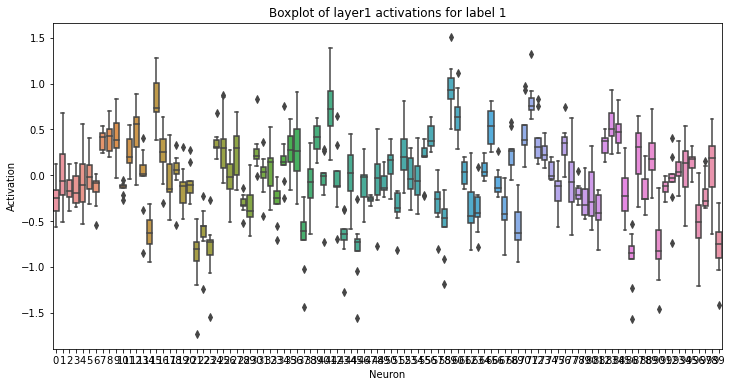

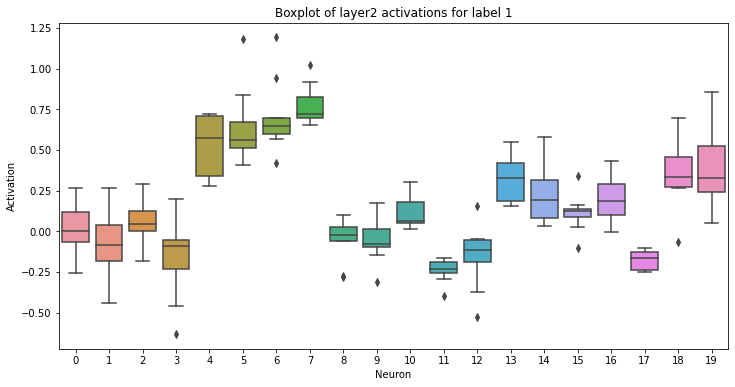

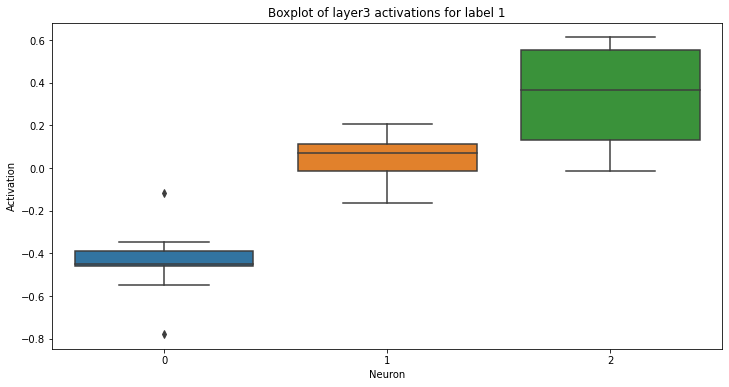

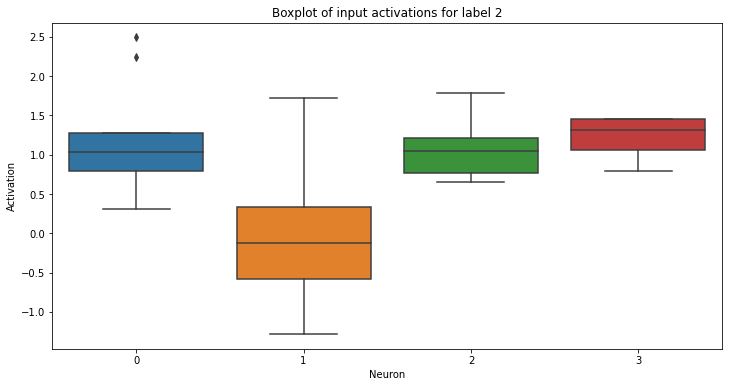

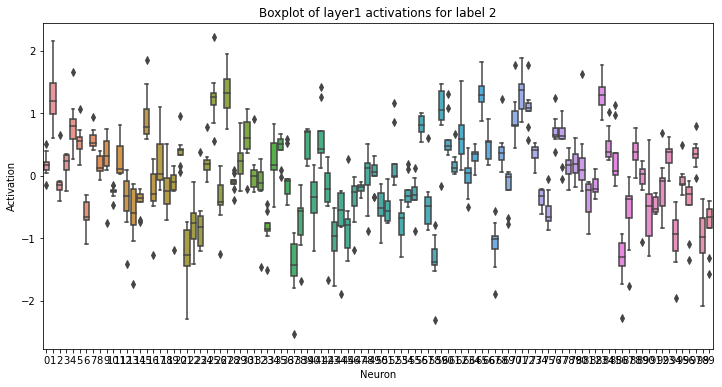

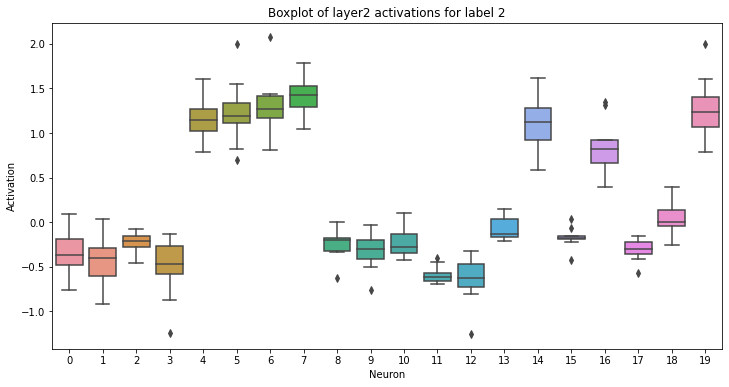

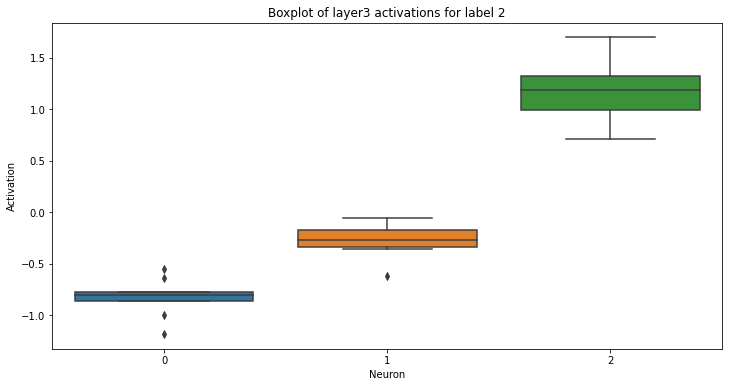

In [33]:
# Function to get activations for each class
def get_activations_for_each_class(model, inputs, labels):
    unique_labels = torch.unique(labels).tolist()
    activations = {label: {} for label in unique_labels}
    for label in unique_labels:
        label_inputs = inputs[labels == label]
        model(label_inputs)
        for layer_name, layer_activations in model.activations.items():
            activations[label][layer_name] = layer_activations.detach().numpy()
    return activations

# Get activations for each class
activations = get_activations_for_each_class(model, X_test_balanced, y_test_balanced)

# Plot boxplots of activations for each class
for label, label_activations in activations.items():
    for layer_name, layer_activations in label_activations.items():
        plt.figure(figsize=(12, 6))
        sns.boxplot(data=layer_activations)
        plt.title(f'Boxplot of {layer_name} activations for label {label}')
        plt.xlabel('Neuron')
        plt.ylabel('Activation')
        plt.show()
